In [10]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch

from dataset_creation.noisy_dataset import create_single_noisy_version
from dataset_creation.utils import get_n_random_noises

# Create a Noisy Dataset

## Requirements And Configuration

The generated noisy traces should be a synthetic version of traces taken from the following dataset ('ethz', 'geofon'):

In [11]:
DATASETS_ORIGINS = ['ethz', 'geofon']
dataset_origin = 'ethz'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

In [12]:
NUM_SAMPLES=3001                    # Trace sample length - If the dataset is built for phasenet: 3001 If it is for EQTransformer: 6000
NUM_NOISY_VERSIONS_PER_TRACE=1      # How many noisy versions to synthesize using a single real trace
DESIRED_SNR=10                   # What SNR level should the noisy synthesized trace be
SAMPLING_RATE=100                   # Sampling Rate - PhaseNet and EQTransformer expect 100Hz
NUM_OF_ORIGINAL_TRACES = 2000       # How many original traces to use for the noisy dataset - use slice from the start

If the generated noises should allow shifting experiments they should be longer than the original trace.
Define how many 1-second-shifts will the dataset enable.

In [13]:
NUM_SHIFTS=6
AUGMENTED_WINDOW_SIZE=NUM_SAMPLES+SAMPLING_RATE*NUM_SHIFTS

Browse The path of the **event** traces that will be used for synthesizing.

In [14]:
DATASET_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_{NUM_SAMPLES}_sample_joachim_noises_energy_ratio_snr/'

Browse The path of the **noise** traces that will be used for synthesizing.

In [15]:
NOISES_PATH='/home/moshe/datasets/GFZ/Noises'

In [16]:
dataset_traces_path = os.path.join(DATASET_PATH, 'original_dataset.pt')[:NUM_OF_ORIGINAL_TRACES]
dataset_labels_path = os.path.join(DATASET_PATH, 'original_labels.pt')[:NUM_OF_ORIGINAL_TRACES]

assert os.path.exists(DATASET_PATH), f'Directory {DATASET_PATH} does not exist'
assert os.path.exists(dataset_traces_path), f'file {dataset_traces_path} does not exist'
assert os.path.exists(dataset_labels_path), f'file {dataset_labels_path} does not exist'

## Load Dataset

In [17]:
dataset=torch.load(dataset_traces_path)[:NUM_OF_ORIGINAL_TRACES]
labels=torch.load(dataset_labels_path)[:NUM_OF_ORIGINAL_TRACES]

num_traces = dataset.shape[0]
num_labels = labels.shape[0]
num_samples = dataset.shape[-1]

assert num_labels==num_traces, f'Expected traces equal num labels.Got {num_traces} traces and {num_labels} labels'
assert num_samples==NUM_SAMPLES, f'Expected {NUM_SAMPLES} in each trace. Got {num_samples}.'

print(f'Loaded {num_traces} traces and corresponding labels.')

Loaded 2000 traces and corresponding labels.


## Create a Noisy Dataset

In [18]:
noised_traces_list, noised_traces_labels_list, augmented_noise_traces_list, factors_list, indices_not_used_list = [],[],[],[], []
pbar = tqdm(range(NUM_NOISY_VERSIONS_PER_TRACE))
for i in pbar:
    # prepare full noises traces
    augmented_noise_traces_created: torch.tensor = get_n_random_noises(num_noises=num_traces, desired_window_size=AUGMENTED_WINDOW_SIZE, noises_path=NOISES_PATH, force_resample=True, filename='aaa', sampling_rate=SAMPLING_RATE, silent_exception_prints=True).squeeze()

    version_noised_traces, version_labels, version_full_noise_traces, version_factors, version_not_included_indices =  create_single_noisy_version(original_traces=dataset, original_labels=labels, augmented_noise_traces=augmented_noise_traces_created, desired_snr=DESIRED_SNR)
    noised_traces_list.append(version_noised_traces)
    noised_traces_labels_list.append(version_labels.unsqueeze(dim=1))
    augmented_noise_traces_list.append(version_full_noise_traces)
    factors_list.append(version_factors.unsqueeze(dim=1))
    indices_not_used_list.extend(version_not_included_indices)
    pbar.set_description(f'Lists len {len(noised_traces_list), len(noised_traces_labels_list), len(augmented_noise_traces_list), len(factors_list)}')

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 2000/2000 [00:10<00:00, 185.32it/s]


Created a list of 2000 random noises of shape torch.Size([3, 3601])
stack to tensor
Stacked to tensor of shape torch.Size([2000, 3, 3601])
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:03<00:00, 500.65it/s]


Created 2000 noisy traces
The following indices are not included []


In [19]:
noised_traces = torch.vstack(noised_traces_list)
noised_traces_labels = torch.vstack(noised_traces_labels_list).squeeze()
augmented_noise_traces = torch.vstack(augmented_noise_traces_list)
noising_factors = torch.vstack(factors_list).squeeze()
indices_not_used = torch.tensor(list(set(indices_not_used_list)))
noised_traces.shape, noised_traces_labels.shape, augmented_noise_traces.shape, noising_factors.shape, indices_not_used.shape

(torch.Size([2000, 3, 3001]),
 torch.Size([2000]),
 torch.Size([2000, 3, 3601]),
 torch.Size([2000]),
 torch.Size([0]))

In [20]:
noisy_dataset_path = os.path.join(DATASET_PATH,f'noisy_dataset_snr_{DESIRED_SNR}')
noisy_dataset_path

'/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_10'

## Save Noisy Dataset to Files

In [21]:
assert os.path.exists(noisy_dataset_path), f'Path {noisy_dataset_path} does not exist.Create it'

In [22]:
torch.save(noised_traces, os.path.join(noisy_dataset_path, 'traces.pt'))
torch.save(augmented_noise_traces, os.path.join(noisy_dataset_path, 'full_noise_traces.pt'))
torch.save(noised_traces_labels, os.path.join(noisy_dataset_path, 'labels.pt'))
torch.save(noising_factors, os.path.join(noisy_dataset_path, 'factors.pt'))
torch.save(indices_not_used, os.path.join(noisy_dataset_path,'indices_not_used'))

## Plot Noising Example

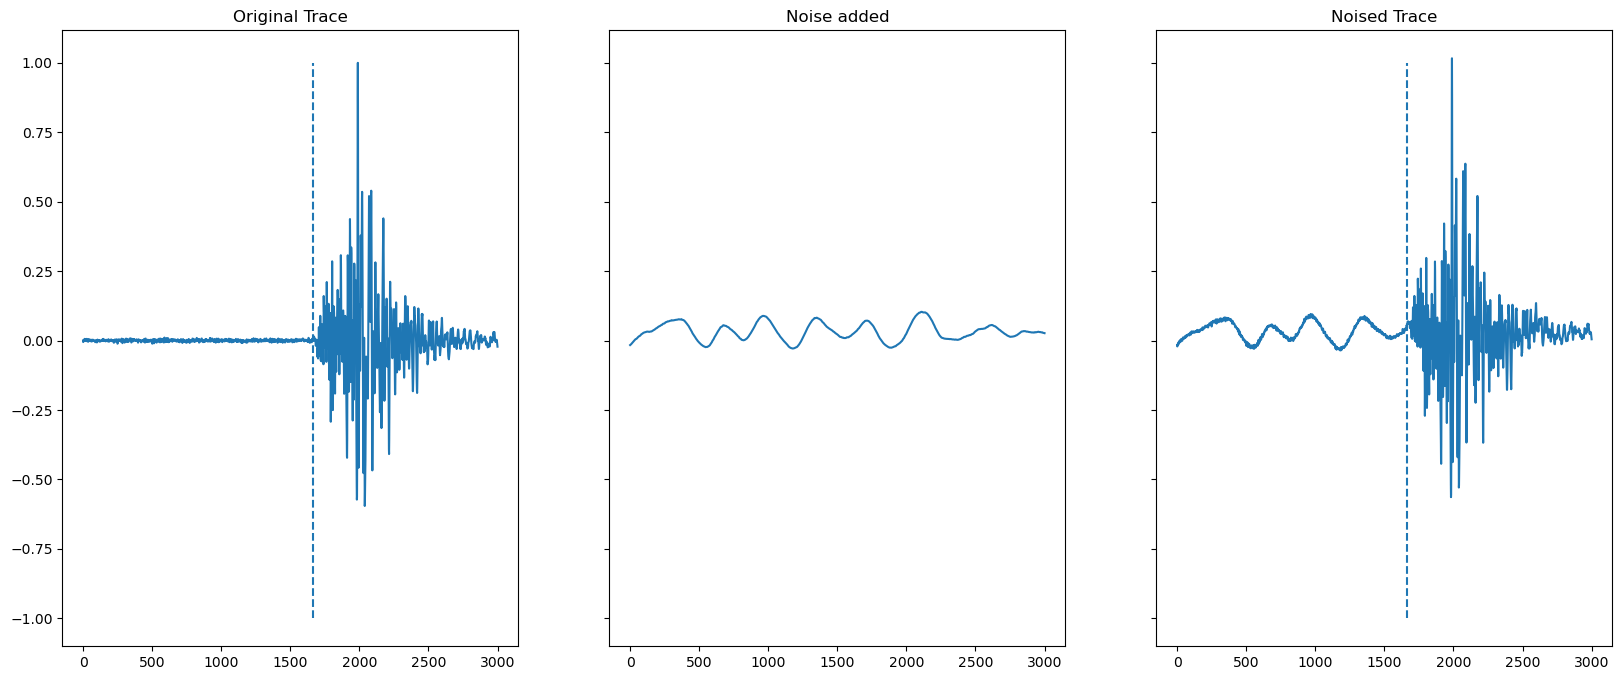

In [23]:
idx = 5
trace  = noised_traces[idx]
label  = noised_traces_labels[idx]
factor = noising_factors[idx]
noise = augmented_noise_traces[idx, :, :trace.shape[-1] ]

fig, (ax_orig,ax_noise, ax_noised) = plt.subplots(1,3,figsize=(20,8), sharey='all')

ax_orig.plot((trace - factor * noise)[0]);
ax_orig.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');
ax_orig.set_title('Original Trace')
ax_noise.plot(factor*noise[0]);
ax_noise.set_title('Noise added')
ax_noised.plot(trace[0]);
ax_noised.set_title('Noised Trace')

ax_noised.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');


# ax_orig.plot((trace - factor * noise).T)
# ax_orig.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed')
# ax_noise.plot(noise.T)
# ax_noised.plot(trace.T)
# ax_noised.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed')

## A Unified Version of The Noisy Datasets

For metrics benchmark it is preferred to create several SNR datasets using the same noises. For each SNR, a single noisy version is created.

First, prepare the noise that will be used for all SNR levels.

In [24]:
# prepare full noises traces
augmented_noise_traces_created: torch.tensor = get_n_random_noises(num_noises=num_traces, desired_window_size=AUGMENTED_WINDOW_SIZE, noises_path=NOISES_PATH, force_resample=True, filename='aaa', sampling_rate=SAMPLING_RATE, silent_exception_prints=True).squeeze()

100%|██████████| 2000/2000 [00:10<00:00, 197.53it/s]


Created a list of 2000 random noises of shape torch.Size([3, 3601])
stack to tensor
Stacked to tensor of shape torch.Size([2000, 3, 3601])


In [25]:
# noised_traces_list, noised_traces_labels_list, augmented_noise_traces_list, factors_list, indices_not_used_list = [],[],[],[], []
desired_snr_list = list(range(1,11))
noisy_dataset_paths = {}
for desired_snr in desired_snr_list:
    noisy_dataset_path = os.path.join(DATASET_PATH,f'noisy_dataset_snr_{desired_snr}')
    assert os.path.exists(noisy_dataset_path), f'Path {noisy_dataset_path} does not exist.Create it'
    noisy_dataset_paths[desired_snr] = noisy_dataset_path

pbar = tqdm(desired_snr_list)
for desired_snr in pbar:
    noised_traces, noised_traces_labels, full_noise_traces_used, factors, indices_not_used_list =  create_single_noisy_version(original_traces=dataset, original_labels=labels, augmented_noise_traces=augmented_noise_traces_created, desired_snr=desired_snr)
    # noised_traces_list.append(version_noised_traces)
    # noised_traces_labels_list.append(version_labels.unsqueeze(dim=1))
    # augmented_noise_traces_list.append(version_full_noise_traces)
    # factors_list.append(version_factors.unsqueeze(dim=1))
    # indices_not_used_list.extend(version_not_included_indices)


    # noised_traces = torch.vstack(noised_traces_list)
    # noised_traces_labels = torch.vstack(noised_traces_labels_list).squeeze()
    # augmented_noise_traces = torch.vstack(augmented_noise_traces_list)
    # noising_factors = torch.vstack(factors_list).squeeze()
    indices_not_used = torch.tensor(list(set(indices_not_used_list)))
    # noised_traces.shape, noised_traces_labels.shape, augmented_noise_traces.shape, noising_factors.shape, indices_not_used.shape
    noisy_dataset_path = noisy_dataset_paths[desired_snr]
    torch.save(noised_traces, os.path.join(noisy_dataset_path, 'traces.pt'))
    torch.save(augmented_noise_traces, os.path.join(noisy_dataset_path, 'full_noise_traces.pt'))
    torch.save(noised_traces_labels, os.path.join(noisy_dataset_path, 'labels.pt'))
    torch.save(noising_factors, os.path.join(noisy_dataset_path, 'factors.pt'))
    torch.save(indices_not_used, os.path.join(noisy_dataset_path,'indices_not_used'))
    pbar.set_description(f'SNR {desired_snr}: {noised_traces.shape[0]} noised traces created and saved.')
    del noised_traces, noised_traces_labels, full_noise_traces_used, factors, indices_not_used_list , indices_not_used

  0%|          | 0/10 [00:00<?, ?it/s]

Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:10<00:00, 182.05it/s]


Created 1816 noisy traces
The following indices are not included [7, 10, 25, 47, 52, 58, 62, 77, 78, 89, 119, 128, 138, 140, 161, 183, 185, 238, 252, 258, 260, 277, 334, 347, 359, 378, 382, 385, 411, 421, 429, 431, 435, 436, 438, 486, 508, 511, 516, 522, 526, 528, 530, 549, 551, 564, 566, 582, 599, 601, 605, 620, 622, 628, 641, 645, 648, 662, 685, 687, 696, 705, 706, 710, 712, 715, 723, 735, 752, 759, 778, 786, 793, 799, 829, 844, 846, 881, 901, 905, 909, 933, 947, 948, 956, 960, 969, 970, 1024, 1029, 1035, 1039, 1052, 1055, 1056, 1060, 1070, 1074, 1089, 1090, 1098, 1100, 1108, 1117, 1132, 1154, 1201, 1209, 1213, 1222, 1239, 1258, 1265, 1268, 1269, 1274, 1279, 1283, 1294, 1307, 1308, 1313, 1335, 1348, 1356, 1386, 1388, 1408, 1433, 1434, 1436, 1442, 1477, 1490, 1492, 1506, 1512, 1517, 1533, 1549, 1552, 1577, 1585, 1596, 1601, 1604, 1612, 1614, 1616, 1617, 1624, 1628, 1632, 1640, 1643, 1664, 1669, 1700, 1703, 1720, 1725, 1728, 1729, 1731, 1736, 1755, 1756, 1842, 1846, 1852, 1857, 1858, 1


100%|██████████| 2000/2000 [00:06<00:00, 296.75it/s]


Created 1920 noisy traces
The following indices are not included [7, 10, 25, 52, 89, 119, 128, 183, 185, 238, 277, 334, 347, 382, 385, 436, 486, 564, 566, 599, 601, 605, 628, 641, 648, 696, 710, 715, 723, 735, 752, 786, 829, 844, 933, 956, 970, 1035, 1039, 1055, 1056, 1060, 1089, 1090, 1098, 1154, 1201, 1239, 1268, 1279, 1348, 1356, 1434, 1442, 1477, 1492, 1512, 1517, 1533, 1549, 1596, 1612, 1616, 1640, 1664, 1669, 1700, 1703, 1725, 1728, 1729, 1842, 1857, 1875, 1934, 1963, 1966, 1967, 1972, 1997]
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:05<00:00, 385.08it/s]


Created 1964 noisy traces
The following indices are not included [7, 10, 119, 128, 185, 238, 277, 334, 347, 436, 628, 710, 715, 829, 956, 1039, 1055, 1056, 1060, 1089, 1090, 1154, 1239, 1279, 1434, 1442, 1492, 1533, 1640, 1664, 1669, 1703, 1725, 1728, 1934, 1963]
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:04<00:00, 451.67it/s]


Created 1983 noisy traces
The following indices are not included [128, 238, 436, 829, 956, 1060, 1089, 1090, 1154, 1442, 1492, 1533, 1664, 1669, 1703, 1725, 1963]
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:03<00:00, 505.31it/s]


Created 1997 noisy traces
The following indices are not included [436, 829, 1669]
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:03<00:00, 526.03it/s]


Created 1999 noisy traces
The following indices are not included [829]
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:03<00:00, 508.09it/s]


Created 2000 noisy traces
The following indices are not included []
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:03<00:00, 514.19it/s]


Created 2000 noisy traces
The following indices are not included []
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:04<00:00, 493.24it/s]


Created 2000 noisy traces
The following indices are not included []
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:03<00:00, 517.98it/s]


Created 2000 noisy traces
The following indices are not included []
